In [30]:
#=
import Pkg

Pkg.add("IJulia")
Pkg.add("JuMP")
Pkg.add("Clp")
Pkg.add("Cbc")
Pkg.add("LinearAlgebra")
Pkg.add("Ipopt")
Pkg.add("Images")
Pkg.add("ImageView")
Pkg.add("StatsBase")
Pkg.add("Combinatorics")
=#

using JuMP
using Clp
using Cbc
using LinearAlgebra
using Ipopt
using Images, ImageView, StatsBase
using Combinatorics
using Plots

tamanho_grid = 4
iteration_count = 0

img_rgb = rand(RGB, tamanho_grid, tamanho_grid)

# Torna 50% das mesas vazias
empty_tables = sample(1:length(img_rgb), Integer(length(img_rgb)/2), replace = false)

for i in eachindex(img_rgb)
    if i in empty_tables
        img_rgb[i] = RGB(1.0, 1.0, 1.0) # Mesas brancas
    else    
        img_rgb[i] = RGB(0.0, 1.0, 0.0) # Mesas verdes
    end
end

ImageView.imshow(img_rgb) # como o restaurante está

iteration = Vector{Float64}()
list_median_satisfaction = Vector{Float64}()

satisfaction = zeros(4,4)

i = 1
j = 1
# cria uma matriz 4x4 que define a satisfacao de cada mesa
for it in img_rgb
    if it == RGB{Float64}(0.0,1.0,0.0)
        satisfaction[i,j] = 5
    end
    if i == tamanho_grid
        i = 0
        j = j+1
    end
    if  i != tamanho_grid
        i=i+1
    end
end

print("Soma satisfação: ", sum(satisfaction[i,j] for i=1:4, j=1:4), "\n")


i = 1
j = 1

# cria uma matriz  4x4 que define o custo de cada mesa 

satisfaction = transpose(satisfaction)

imagem_dos_caminhos = rand(RGB, tamanho_grid, tamanho_grid)

# Torna 50% das mesas vazias

# Crio todos os caminhos possiveis de se fazer quando voce está em um ponto, impedindo que você atravesse o restaurante em um unico movimento

custo_simples = zeros(tamanho_grid,tamanho_grid)
pizzas_requisitadas = zeros(tamanho_grid,tamanho_grid)
pizzas = 4
mesas_vazias = zeros(tamanho_grid,tamanho_grid)

interação = 1
for i in satisfaction
    print(i)
    if 4<= i <= 5.0
    pizzas_requisitadas[interação] = 1
    elseif 0< i<= 3
        pizzas_requisitadas[interação] = 2
    end
    interação = interação+1
end



interação = 1
for i in satisfaction
    print(i)
    if  i == 5.0
    custo_simples[interação] = 1
    elseif i == 4.0
        custo_simples[interação] = 3
    elseif i == 3.0
        custo_simples[interação] = 5
    elseif i == 2.0
        custo_simples[interação] = 7
    elseif i == 1.0
        custo_simples[interação] = 9
    end
    interação = interação+1
end

print(custo_simples)


if length(findall(a->a==1, custo_simples)) <= pizzas
    pizzas = length(findall(a->a==1, custo_simples))

end

Soma satisfação: 40.0
5.05.00.05.05.00.00.00.05.05.00.00.05.00.05.00.05.05.00.05.05.00.00.00.05.05.00.00.05.00.05.00.0[1.0 1.0 1.0 1.0; 1.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0; 1.0 0.0 0.0 0.0]

In [31]:
while iteration_count <= 100
    n = tamanho_grid

    nmodel =  Model(Cbc.Optimizer)
    @variable(nmodel, x[1:n, 1:n], Bin) # mesas que vao ser escolhidas para serem atendidas 
    @objective(nmodel,  Max, sum(x[i,j]*custo_simples[i,j] for i = 1:n, j=1:n)) #objetivo de maximizar o custo (note que o custo aumenta conforme a satisfação diminui, logo maximizar o custo é o mesmo de maximizar a satisfação)
    @constraint(nmodel, sum(x[i,j] for i = 1:n, j=1:n) >=  0)
    @constraint(nmodel, [i=1:n, j=1:n], pizzas_requisitadas[i,j]-x[i,j]>= 0) # essa retrição impossibilita ele de atender mesas vazias
    @constraint(nmodel, cliente1, sum(x[i,j]*pizzas_requisitadas[i,j] for i = 1:n, j=1:n) == pizzas)# essa restrição limita a quantidade de mesas a serem atendidas

    optimize!(nmodel)

    W = value.(x)


    # W = value.(x)

    findall(l->l==1, W)

    lista_1 = []
    lista_2 = []
    lista_a = []
    lista_b = []
    lista_c = []
    for i in findall(a -> a == 1, W)
        print()
        pato = ((i[1]-1)*4)+i[2]
        push!(lista_1, pato)
        push!(lista_2, i[2])
        push!(lista_b, i[1])
        push!(lista_c, i[2])
    end

    lista_a = [lista_1]

    print("Todas as mesas que o garçom passou: \n", lista_a)

    for i in 1:16
        if i ∉ lista_a[1] && transpose(satisfaction)[i] != 0 && transpose(satisfaction)[i] != 1 
            transpose(satisfaction)[i] = transpose(satisfaction)[i] -1
        elseif i ∉ lista_a[1] && transpose(satisfaction)[i] == 1
            transpose(satisfaction)[i] = transpose(satisfaction)[i] -2
        elseif i in lista_a[1]
            transpose(satisfaction)[i] = 5
        end
    end

    findall(l->l==1, W)

    satisfaction

    # Loop geral

    # Acertar satisfação depois de uma iteração 
    
    img_tables_passed = rand(RGB, tamanho_grid, tamanho_grid)

    # Gráfico de satisfação
    for (i, value) in enumerate(transpose(satisfaction))

        img_tables_passed[i] = RGB{Float64}(1.0, 1.0, 1.0)
        
        if Integer(value) == 5
            img_rgb[i] = RGB{Float64}(0.0, 1.0, 0.0)
        elseif Integer(value) == 4 
            img_rgb[i] = RGB{Float64}(0.5, 1.0, 0.0)
        elseif Integer(value) == 3 
            img_rgb[i] = RGB{Float64}(1.0, 1.0, 0.0)
        elseif Integer(value) == 2 
            img_rgb[i] = RGB{Float64}(1.0, 0.5, 0.0)
        elseif Integer(value) == 1 
            img_rgb[i] = RGB{Float64}(1.0, 0.0, 0.0)
        elseif Integer(value) == 0 
            img_rgb[i] = RGB{Float64}(1.0, 1.0, 1.0) 
        elseif Integer(value) == -1
            img_rgb[i] = RGB{Float64}(0.0, 0.0, 0.0) 
        end
    end

    count = 0
    for i in lista_a[1]
        if count == 0
            img_tables_passed[i] = RGB{Float64}(1.0, 0.0, 0.0)
            count = 1
        else
            img_tables_passed[i] = RGB{Float64}(0.0, 0.0, 1.0)
        end
    end

    iteration_count += 1

    if iteration_count <= 9
        non_empty_tables = 9 - iteration_count 
    else
        non_empty_tables = 0
    end
    
    #print("\n\nNon empty tables", non_empty_tables)

    append!(iteration, iteration_count)
    append!(list_median_satisfaction, sum(satisfaction[i,j] for i=1:4, j=1:4)/(16 - non_empty_tables))

    # Adicionar um cliente a cada nova iteração (redução de uma mesa vazia) --> NOVO LOOP




    satisfaction
    interation = 1

    for i in satisfaction
        if 4<= i <= 5.0
        pizzas_requisitadas[interation] = 1
        elseif 0< i<= 3
            pizzas_requisitadas[interation] = 2
        end
        interation = interation+1
    end

    interation = 1
    for i in satisfaction
        
        if  i == 5.0
        custo_simples[interation] = 1
        elseif i == 4.0
            custo_simples[interation] = 3
        elseif i == 3.0
            custo_simples[interation] = 10
        elseif i == 2.0
            custo_simples[interation] = 18
        elseif i == 1.0
            custo_simples[interation] = 100
        end
        interation = interation+1
    end

    mesa_nova = 0

    for i in 1:16
        if satisfaction[i] == 0
            satisfaction[i] = 5
            mesa_nova = i
            custo_simples[mesa_nova] = 100000
            pizzas_requisitadas[mesa_nova] = 1
            break
        end
    end

    total = 0
    
    for i in 1:16
        if satisfaction[i] == -1
            total = total+0
        else
            total = total + satisfaction[i]
        end
    end   

    # print(custo_simples)

    # Resultados -> Favor passar várias iterações em 3.4.

    if iteration_count == 100
        print("Satisfação média atual: ", total/(16 - non_empty_tables), "\n")
        print("\nSatisfação ao longo das iterações: \n", list_median_satisfaction)

        ImageView.closeall()
        ImageView.imshow(transpose(img_rgb))
        ImageView.imshow(transpose(img_tables_passed))
    end
end

Todas as mesas que o garçom passou: 
Array{Any,1}[[1, 5, 13, 2]]Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 4 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -4 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Gomory was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Knapsack was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Clique was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
MixedIntegerRounding2 was tried 0 times and created 0 cuts of which 0 were active after adding rounds

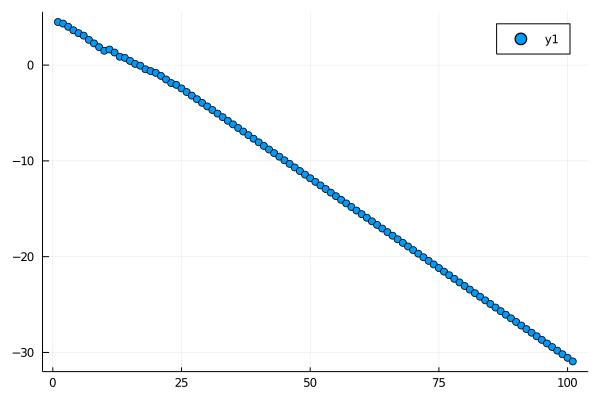

In [32]:
scatter(iteration, list_median_satisfaction)